## NIPS Baseline Spin Test 

### Imports

In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
from env.imports import *

In [73]:
import importlib
import data

import data.data_utils
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome
from models import *
from data import * 
from sim import *

import models
import models.metrics
from models.metrics import *


## Specify connectome and transcriptome

Assign features and targets

In [91]:
# S400
X = load_transcriptome(parcellation='S400', run_PCA=True, omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='expression')
Y_sc = load_connectome(parcellation='S400', omit_subcortical=False, measure='SC', hemisphere='both', include_labels=False)
Y_fc, region_labels, lh_indices, rh_indices = load_connectome(parcellation='S400', omit_subcortical=False, measure='FC', hemisphere='both', include_labels=True)
Y = Y_fc
coords = load_coords(parcellation='S400', omit_subcortical=True, hemisphere='both')

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Subset all data using valid indices
X = X[valid_indices]
Y = Y[valid_indices][:, valid_indices]


Number of components for 95% variance PCA: 27


## Fit SCM model

In [92]:
# Adapted from https://github.com/kpisti/SCM/tree/v1.0. Below implementation is aligned with Ridge Regression model from full paper.
def fit_scm(X, Y, alpha=0.0, verbose=True):
    """
    Fit Structural Covariance Model (SCM) to predict connectivity from gene expression.
    
    Args:
        X: Gene expression PCA matrix (regions x gene_PCA_dim)
        Y: Connectivity matrix (regions x regions) 
        alpha: Regularization parameter for ridge regression
        
    Returns:
        O: Estimated rule matrix (gene_PCA_dim x gene_PCA_dim)
        Y_pred: Predicted connectivity matrix (regions x regions)
        objective: Objective function value
    """
    # Check memory requirements before proceeding
    if verbose:
        print(f"X shape: {X.shape}")
        # Calculate memory needed for Kronecker product
        kron_size = (X.shape[0]**2) * (X.shape[1]**2) * 8  # 8 bytes per float64
        available_mem = psutil.virtual_memory().available
        if kron_size > available_mem:
            raise MemoryError(f"Kronecker product would require {kron_size/1e9:.2f}GB but only {available_mem/1e9:.2f}GB available")
    
    # Compute Kronecker product of X with itself to obtain K matrix
    K = np.kron(X, X)  
    if verbose: print(f"K shape after Kronecker: {K.shape}")
    
    # Flatten connectivity matrix Y
    if verbose: print(f"Y shape before flatten: {Y.shape}")
    Y_flat = Y.flatten() 
    if verbose: print(f"Y_flat shape: {Y_flat.shape}")
    
    # Compute K transpose multiplied by K
    K_transpose_K = np.dot(K.T, K) 
    if verbose: print(f"K_transpose_K shape: {K_transpose_K.shape}")
    
    # Add regularization term
    # K_transpose_K /= np.linalg.norm(K_transpose_K)
    K_reg = K_transpose_K + alpha * np.identity(K_transpose_K.shape[0]) 
    if verbose: print(f"K_reg shape: {K_reg.shape}")

    # Compute the pseudo-inverse solution
    K_pseudo_inv = np.linalg.pinv(K_reg).dot(K.T)
    if verbose: print(f"K_pseudo_inv shape: {K_pseudo_inv.shape}")
    
    # Estimate the rule matrix in vectorized form
    O_flat = K_pseudo_inv.dot(Y_flat)
    if verbose: print(f"O_flat shape: {O_flat.shape}")
    
    # Compute residuals and objective
    residuals = Y_flat - np.dot(K, O_flat)
    if verbose: print(f"Residuals shape: {residuals.shape}")
    residual_norm = np.linalg.norm(residuals)

    K_proj = np.dot(K, K_pseudo_inv)
    if verbose: print(f"K_proj shape: {K_proj.shape}")
    
    tau = np.trace(np.identity(K_proj.shape[0]) - K_proj)
    if verbose: print(f"tau: {tau}")
    
    objective = residual_norm*residual_norm/tau/tau # ** 2)
    if verbose: print(f"objective: {objective}")
    
    # Reshape O to original dimensions
    O = O_flat.reshape(X.shape[1], X.shape[1])
    
    # Predict connectivity matrix
    Y_pred = np.dot(X, np.dot(O, X.T))
    
    # Min-max scale Y_pred to [-1,1] range
    return O, Y_pred, objective

def fit_scm_closed(X, Y, alpha=0.0):
    """
    Fit Structural Covariance Model (SCM) using closed form solution.
    
    Args:
        X: Gene expression PCA matrix (regions x gene_PCA_dim)
        Y: Connectivity matrix (regions x regions)
        alpha: Regularization parameter
        
    Returns:
        O: Estimated rule matrix (gene_PCA_dim x gene_PCA_dim) 
        Y_pred: Predicted connectivity matrix (regions x regions)
    """
    A = X.T @ X + alpha * np.eye(X.shape[1])
    A_inv = np.linalg.inv(A)
    O = A_inv @ X.T @ Y @ X @ A_inv
    Y_pred = X @ O @ X.T
    return O, Y_pred

def fit_scm_closed_with_scalar_bias(X, Y, alpha=0.0):
    """
    Fit Structural Covariance Model (SCM) with a learned scalar bias term.
    
    Args:
        X: Gene expression PCA matrix (regions x gene_PCA_dim)
        Y: Connectivity matrix (regions x regions)
        alpha: Regularization parameter for ridge regression
        
    Returns:
        O: Estimated bilinear operator (d x d)
        b: Learned scalar bias
        Y_pred: Predicted connectivity matrix (XOXᵀ + b)
    """
    # Compute inverse of regularized Gram matrix
    A = X.T @ X + alpha * np.eye(X.shape[1])
    A_inv = np.linalg.inv(A)

    # Estimate O from closed-form solution
    O = A_inv @ X.T @ Y @ X @ A_inv

    # Compute bilinear prediction
    Y_lin = X @ O @ X.T

    # Learn scalar bias to minimize mean residual
    b = np.mean(Y - Y_lin)

    # Final prediction with scalar bias
    Y_pred = Y_lin + b

    return O, b, Y_pred

alpha=0      | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.00 | Tr(H)=729.00
alpha=1e-05  | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.00 | Tr(H)=729.00
alpha=0.0001 | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.00 | Tr(H)=729.00
alpha=0.001  | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.01 | Tr(H)=728.99
alpha=0.01   | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.06 | Tr(H)=728.94
alpha=0.1    | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.65 | Tr(H)=728.35
alpha=1      | GCV=1.1321e-07 | Residual=6.9415e+01 | τ=206302.44 | Tr(H)=722.56
alpha=10     | GCV=1.1332e-07 | Residual=6.9465e+01 | τ=206355.23 | Tr(H)=669.77
alpha=100    | GCV=1.1874e-07 | Residual=7.1201e+01 | τ=206630.65 | Tr(H)=394.35


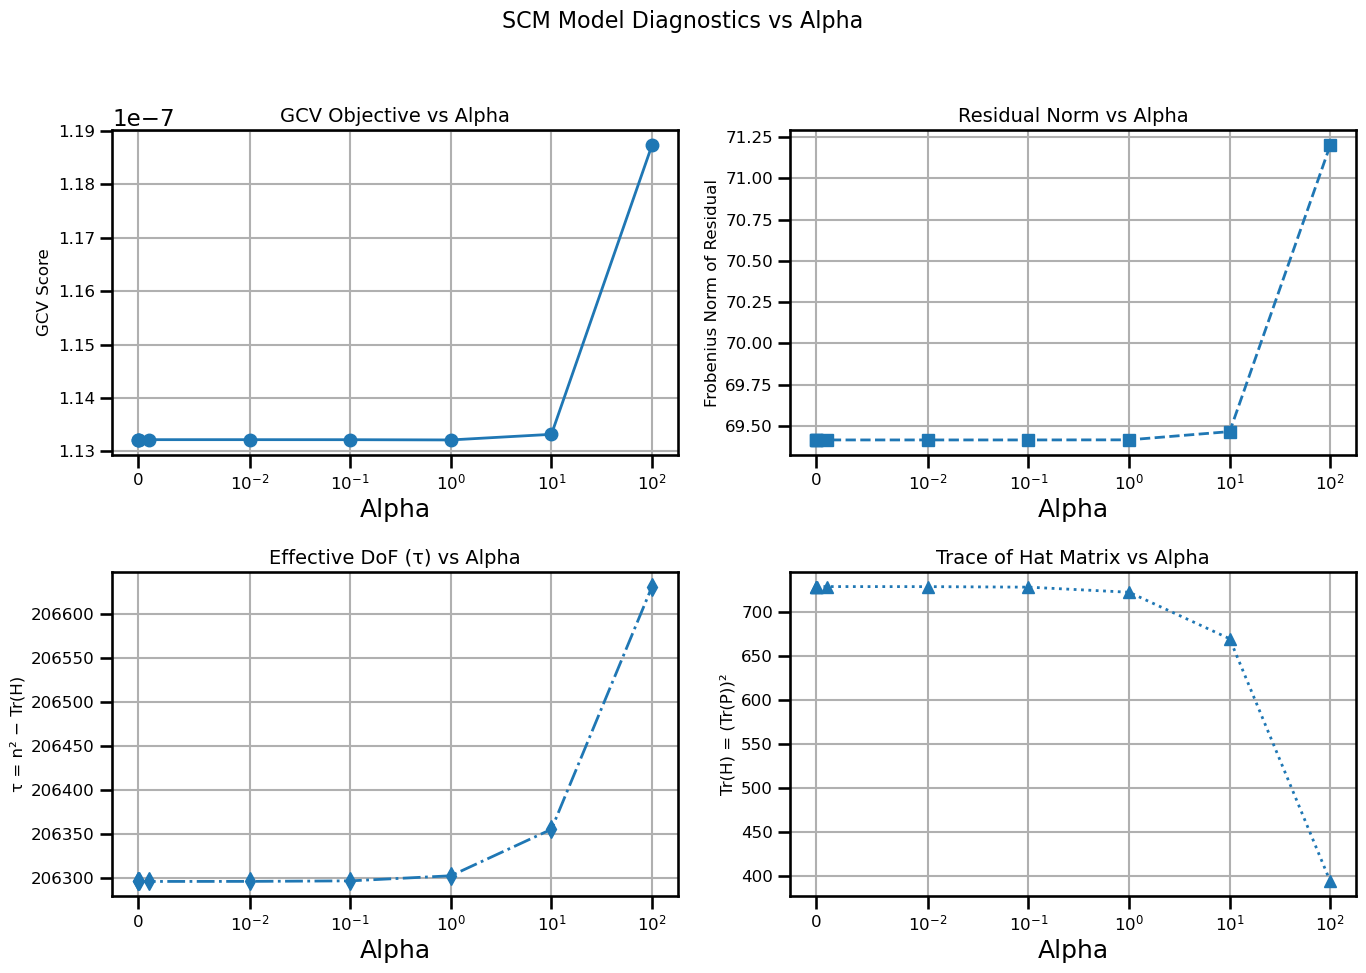

In [93]:
def fit_scm_closed_with_gcv(X, Y, alpha=0.0, return_all=False):
    """
    Closed-form SCM fit with optional GCV scoring.

    Args:
        X (n x d): Input feature matrix (e.g. PCA of gene expression)
        Y (n x n): Symmetric target matrix (e.g. SC or FC)
        alpha: Ridge penalty
        return_all: If True, returns intermediate terms including GCV

    Returns:
        O: Learned operator
        Y_pred: Predicted target matrix
        GCV: Generalized cross-validation objective
    """
    n, d = X.shape
    A = X.T @ X + alpha * np.eye(d)
    A_inv = np.linalg.inv(A)

    O = A_inv @ X.T @ Y @ X @ A_inv
    Y_pred = X @ O @ X.T

    # Residual Frobenius norm
    residual_norm = np.linalg.norm(Y - Y_pred, ord='fro')

    # Compute hat matrix trace: Tr(H) = (Tr(P))^2
    P = X @ A_inv @ X.T
    tr_H = np.trace(P) ** 2
    tau = n**2 - tr_H

    gcv = (residual_norm ** 2) / (tau ** 2)

    if return_all:
        return O, Y_pred, gcv, residual_norm, tau, tr_H
    else:
        return O, Y_pred, gcv

def grid_search_alpha_with_gcv(X, Y, alpha_values):
    gcv_scores = []
    residuals = []
    taus = []
    traces = []

    for alpha in alpha_values:
        _, _, gcv, res_norm, tau, tr_H = fit_scm_closed_with_gcv(X, Y, alpha=alpha, return_all=True)
        print(f"alpha={alpha:<6} | GCV={gcv:.4e} | Residual={res_norm:.4e} | τ={tau:.2f} | Tr(H)={tr_H:.2f}")
        gcv_scores.append(gcv)
        residuals.append(res_norm)
        taus.append(tau)
        traces.append(tr_H)

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs = axs.flatten()

    axs[0].plot(alpha_values, gcv_scores, 'o-', lw=2)
    axs[0].set_xscale('symlog', linthresh=0.01)
    axs[0].set_title('GCV Objective vs Alpha')
    axs[0].set_ylabel('GCV Score')
    axs[0].grid(True)

    axs[1].plot(alpha_values, residuals, 's--', lw=2)
    axs[1].set_xscale('symlog', linthresh=0.01)
    axs[1].set_title('Residual Norm vs Alpha')
    axs[1].set_ylabel('Frobenius Norm of Residual')
    axs[1].grid(True)

    axs[2].plot(alpha_values, taus, 'd-.', lw=2)
    axs[2].set_xscale('symlog', linthresh=0.01)
    axs[2].set_title('Effective DoF (τ) vs Alpha')
    axs[2].set_ylabel('τ = n² − Tr(H)')
    axs[2].grid(True)

    axs[3].plot(alpha_values, traces, '^:', lw=2)
    axs[3].set_xscale('symlog', linthresh=0.01)
    axs[3].set_title('Trace of Hat Matrix vs Alpha')
    axs[3].set_ylabel('Tr(H) = (Tr(P))²')
    axs[3].grid(True)

    for ax in axs:
        ax.set_xlabel('Alpha')
        ax.tick_params(labelsize=12)
        ax.set_title(ax.get_title(), fontsize=14)
        ax.set_ylabel(ax.get_ylabel(), fontsize=12)

    plt.suptitle('SCM Model Diagnostics vs Alpha', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return {
        'alpha': alpha_values,
        'gcv': gcv_scores,
        'residual': residuals,
        'tau': taus,
        'tr_H': traces
    }

# Define alpha values and run search
alphas = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
results = grid_search_alpha_with_gcv(X, Y, alphas)


SCM model metrics:
Pearson r: 0.560
R-squared: 0.30452
MSE: 0.02327


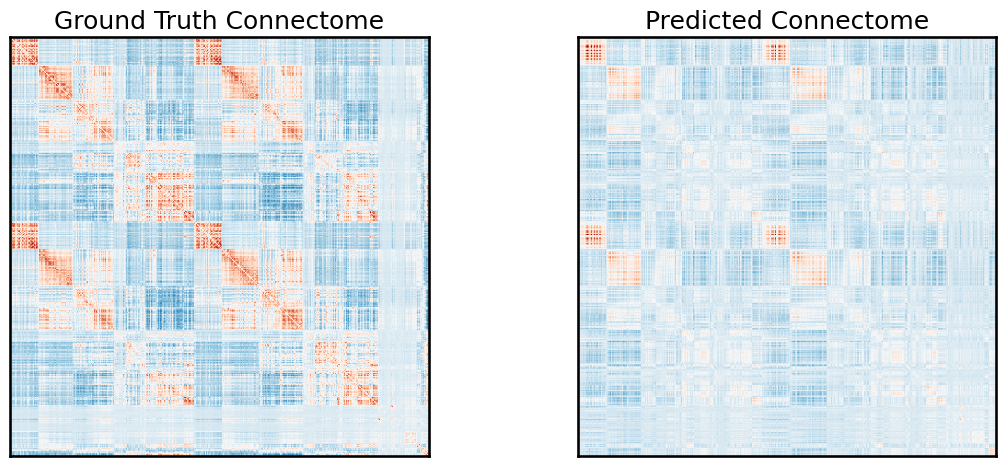

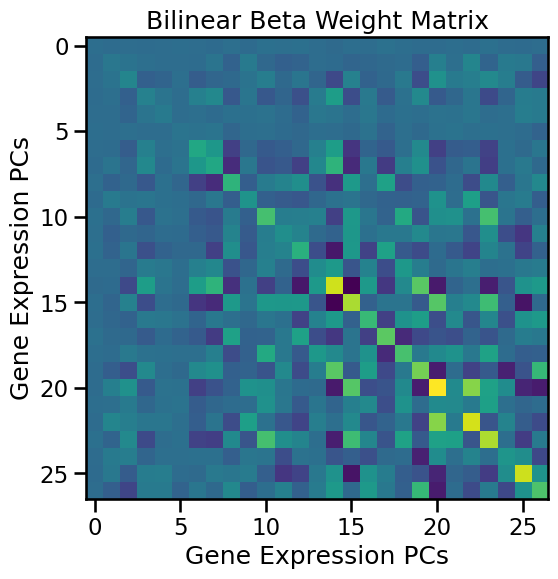

In [94]:
O, Y_pred = fit_scm_closed(X, Y, alpha=0.0)

# Flatten matrices for calculations
y_true = Y.flatten()
y_pred = Y_pred.flatten()

# Metrics
pearson_r, _ = stats.pearsonr(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
print("\nSCM model metrics:")
print(f"Pearson r: {pearson_r:.3f}")
print(f"R-squared: {r2:.5f}") 
print(f"MSE: {mse:.5f}")

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ground truth connectome
im1 = ax1.imshow(Y, cmap='RdBu_r', vmin=-0.75, vmax=1)
ax1.set_title('Ground Truth Connectome')
ax1.set_xticks([])
ax1.set_yticks([])

# Plot predicted connectome  
im2 = ax2.imshow(Y_pred, cmap='RdBu_r', vmin=-0.75, vmax=1)
ax2.set_title('Predicted Connectome')
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
plt.imshow(O)
#plt.colorbar(label='Beta Weight')
plt.title('Bilinear Beta Weight Matrix')
plt.xlabel('Gene Expression PCs')
plt.ylabel('Gene Expression PCs') 
plt.show()



SCM model metrics:
Pearson r: 0.560
R-squared: 0.31329
MSE: 0.02298


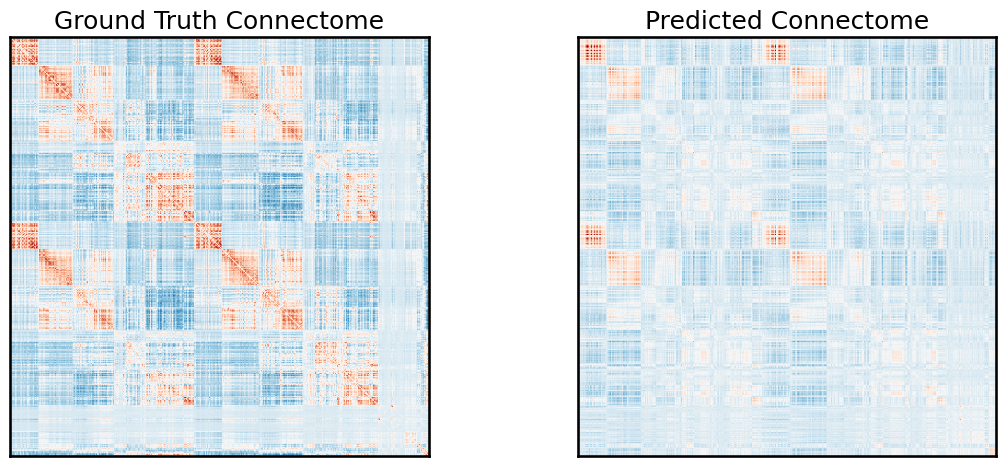

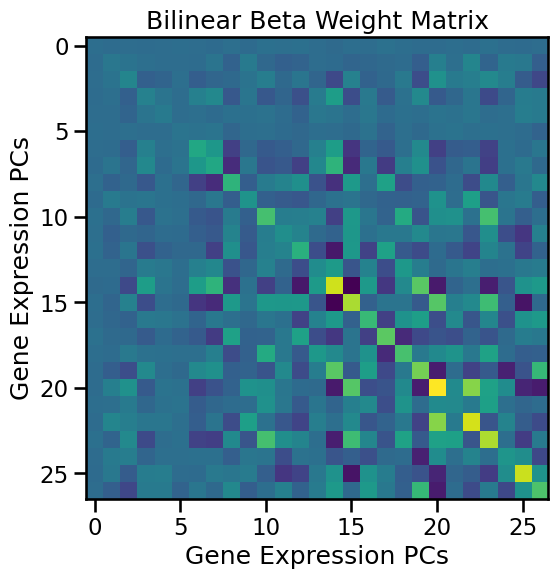

In [95]:
O, b, Y_pred = fit_scm_closed_with_scalar_bias(X, Y, alpha=0.1)

# Flatten matrices for calculations
y_true = Y.flatten()
y_pred = Y_pred.flatten()

# Metrics
pearson_r, _ = stats.pearsonr(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
print("\nSCM model metrics:")
print(f"Pearson r: {pearson_r:.3f}")
print(f"R-squared: {r2:.5f}") 
print(f"MSE: {mse:.5f}")

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ground truth connectome
im1 = ax1.imshow(Y, cmap='RdBu_r', vmin=-0.75, vmax=1)
ax1.set_title('Ground Truth Connectome')
ax1.set_xticks([])
ax1.set_yticks([])

# Plot predicted connectome  
im2 = ax2.imshow(Y_pred, cmap='RdBu_r', vmin=-0.75, vmax=1)
ax2.set_title('Predicted Connectome')
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
plt.imshow(O)
#plt.colorbar(label='Beta Weight')
plt.title('Bilinear Beta Weight Matrix')
plt.xlabel('Gene Expression PCs')
plt.ylabel('Gene Expression PCs') 
plt.show()


### Comparison to null spin tests

In [66]:
spins_df = pd.read_csv('./data/enigma/1000_null_spins.csv')
spins_df.head()


,cortical_spins,subcortical_spins,cortical_cost,subcortical_cost,total_cost,mean_error_rank,total_cost_rank,SA_error_rank,poly_error_rank,standardized_SA_error,...,SA_lambda_PCA,SA_inf_PCA,poly_a1,poly_a2,poly_a3,poly_a4,poly_a1_PCA,poly_a2_PCA,poly_a3_PCA,poly_a4_PCA
0,"[34, 35, 33, 102, 101, 99, 140, 152, 100, 174,...","[53, 52, 49, 51, 54, 50, 33, 34, 42, 48, 29, 4...",14676.201766,2342.839271,17019.041037,404.000000,665.0,60.0,487.0,2.020939,...,39.069998,-0.164938,0.892056,-0.020372,0.000229,-7.939946e-07,0.892085,-0.026995,0.000288,-1.034092e-06
1,"[31, 33, 135, 171, 162, 154, 35, 98, 158, 101,...","[32, 55, 53, 52, 31, 51, 8, 34, 6, 54, 10, 50,...",14223.071041,3079.720650,17302.791691,871.000000,776.0,925.0,912.0,7.739180,...,18.690197,0.100440,0.895892,-0.017695,0.000150,-3.050474e-07,0.815554,-0.019567,0.000131,-1.852663e-07
2,"[165, 166, 124, 167, 114, 125, 133, 119, 113, ...","[54, 55, 32, 46, 48, 50, 3, 29, 5, 31, 30, 34,...",14066.498745,2193.130687,16259.629432,254.000000,387.0,156.0,219.0,3.187752,...,34.530601,-0.104178,0.990390,-0.023210,0.000244,-7.754920e-07,0.969185,-0.029299,0.000301,-1.024482e-06
3,"[48, 106, 110, 109, 55, 199, 179, 194, 54, 182...","[2, 55, 0, 49, 54, 50, 29, 3, 13, 51, 4, 47, 9...",13520.685713,2364.827011,15885.512724,453.333333,286.0,422.0,652.0,5.352753,...,25.958393,0.007003,0.955965,-0.020002,0.000183,-4.740132e-07,0.908789,-0.023540,0.000193,-4.967189e-07
4,"[185, 184, 64, 86, 87, 63, 85, 187, 61, 58, 56...","[4, 53, 46, 50, 28, 42, 13, 0, 34, 47, 49, 48,...",13896.760066,3108.012640,17004.772706,586.333333,659.0,562.0,538.0,6.010256,...,25.778299,0.011122,0.946094,-0.020804,0.000202,-5.556576e-07,0.959338,-0.027698,0.000260,-7.725980e-07


In [67]:
# Get list of indices to use for each null spin
cortical_spins_list = spins_df['cortical_spins'].tolist()
cortical_spins_list = [eval(x) for x in cortical_spins_list]
cortical_spin_indices = np.array(cortical_spins_list).reshape(1000, 400)
print(cortical_spin_indices.shape)

# Get list of indices to use for each null spin for subcortical regions
subcortical_spins_list = spins_df['subcortical_spins'].tolist()
subcortical_spins_list = [eval(x) for x in subcortical_spins_list]
subcortical_spin_indices = np.array(subcortical_spins_list).reshape(1000, 56)
print(subcortical_spin_indices.shape)

(1000, 400)
(1000, 56)


permutation: 0
permutation: 50


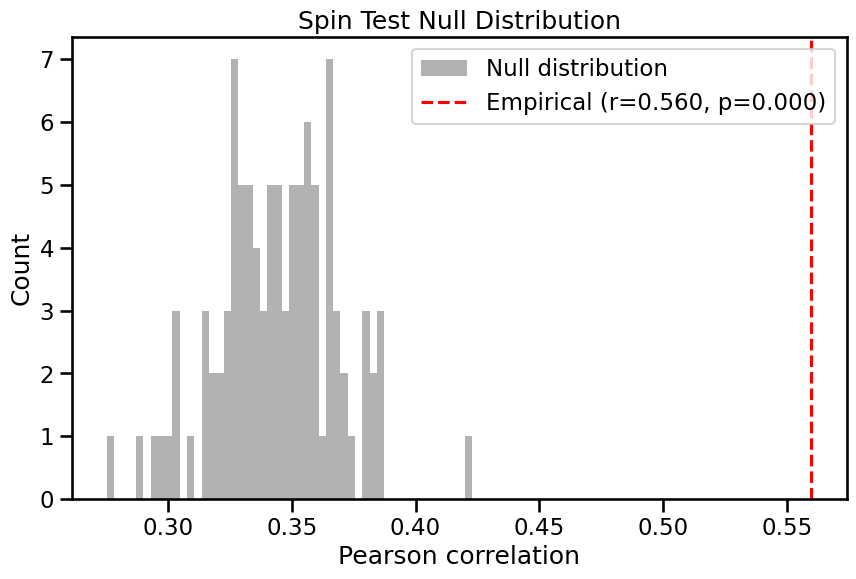

In [68]:
# Spatial null model
'''
- Idea is that autocorrelation in gene expression, X, may drive the PLS solution
- To address this we can generate a spatial permutation of either the gene expression data or the connectome data an refit the PLS model
- Here we will permute the target data as in Hansen, 2021

- The spin test embodies the null hypothesis that genes and connectivity values are spatially correlated with each other because of inherent spatial autocorrelation.
- In Hansen, 2021, the P value is computed as the proportion of null singular values that are greater in magnitude than the empirical singular values.
- Thus, the P value represents the probability that the observed spatial correspondence between genes and connectivity values could occur by randomly correlating maps with comparable spatial autocorrelation

- In our case the null distribution could be the pearson-r values (or other metrics) of the best PLS model as determined by elbow point. 
'''

def run_scm_spin_test_precomputed(X, Y_true, valid_indices, spins_df, n_perms=1000, sort_spins='mean_error_rank'):
    """
    Run spin test using precomputed spins to generate null distribution
    
    Parameters:
    -----------
    X : array-like
        Gene expression data matrix (n_regions x n_genes)
    Y_true : array-like 
        Connectivity matrix (n_regions x n_regions)
    spins_df : pandas DataFrame
        DataFrame containing precomputed spin indices
    n_components : int
        Number of PLS components to use
    n_perms : int
        Number of null permutations to run
    shuffle_target : bool
        If True, shuffle connectivity matrix, if False shuffle gene expression
        
    Returns:
    --------
    empirical_corr : float
        Correlation between true and predicted values
    p_value : float
        Spin test p-value 
    null_corrs : array
        Distribution of null correlations
    """
    
    # Sort spins_df by standardized_SA_error in ascending order
    spins_df = spins_df.sort_values(sort_spins, ascending=True)

    # Get spin indices
    cortical_spins_list = spins_df['cortical_spins'].tolist()[:n_perms]
    cortical_spins_list = [eval(x) for x in cortical_spins_list]
    cortical_spin_indices = np.array(cortical_spins_list)
    
    subcortical_spins_list = spins_df['subcortical_spins'].tolist()[:n_perms]
    subcortical_spins_list = [eval(x) for x in subcortical_spins_list]
    subcortical_spin_indices = np.array(subcortical_spins_list)

    # Fit model to true data
    O, Y_pred = fit_scm_closed(X, Y_true)
    
    # Calculate empirical correlation
    Y_pred_empirical = Y_pred
    empirical_corr = pearsonr(Y_true.flatten(), Y_pred_empirical.flatten())[0]

    # Initialize array for null correlations
    null_corrs = np.zeros(n_perms)
    
    # Generate null distribution
    for i in range(n_perms):
        if i % 50 == 0:
            print(f"permutation: {i}")
            
        # Get spin indices for this permutation
        cortical_spin_idx = cortical_spin_indices[i]
        subcortical_spin_idx = subcortical_spin_indices[i]
        
        # Shuffle gene expression
        Y_rotated = Y_true
        X_cortical_rotated = X[cortical_spin_idx]
        X_subcortical_rotated = X[subcortical_spin_idx]
        X_rotated = np.vstack([X_cortical_rotated, X_subcortical_rotated])
        X_rotated = X_rotated[valid_indices]

        # Fit SCM model on rotated data and get predictions
        O_null, Y_pred_null = fit_scm_closed(X_rotated, Y_rotated)
        null_corrs[i] = pearsonr(Y_rotated.flatten(), Y_pred_null.flatten())[0]

    # Calculate p-value
    p_value = np.mean(null_corrs >= empirical_corr)

    # Plot null distribution
    plt.figure(figsize=(10, 6))
    plt.hist(null_corrs, bins=50, alpha=0.6, color='gray', label='Null distribution')
    plt.axvline(empirical_corr, color='red', linestyle='--', 
                label=f'Empirical (r={empirical_corr:.3f}, p={p_value:.3f})')
    plt.xlabel('Pearson correlation')
    plt.ylabel('Count')
    plt.title('Spin Test Null Distribution')
    plt.legend()
    plt.show()
    
    return empirical_corr, p_value, null_corrs

# Example usage:
empirical_corr, p_value, null_distribution = run_scm_spin_test_precomputed(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y, 
    spins_df=spins_df,
    sort_spins='mean_error_rank',
    n_perms=100
)

permutation: 0
permutation: 50
permutation: 100
permutation: 150
permutation: 200
permutation: 250
permutation: 300
permutation: 350
permutation: 400
permutation: 450
permutation: 500
permutation: 550
permutation: 600
permutation: 650
permutation: 700
permutation: 750
permutation: 800
permutation: 850
permutation: 900
permutation: 950


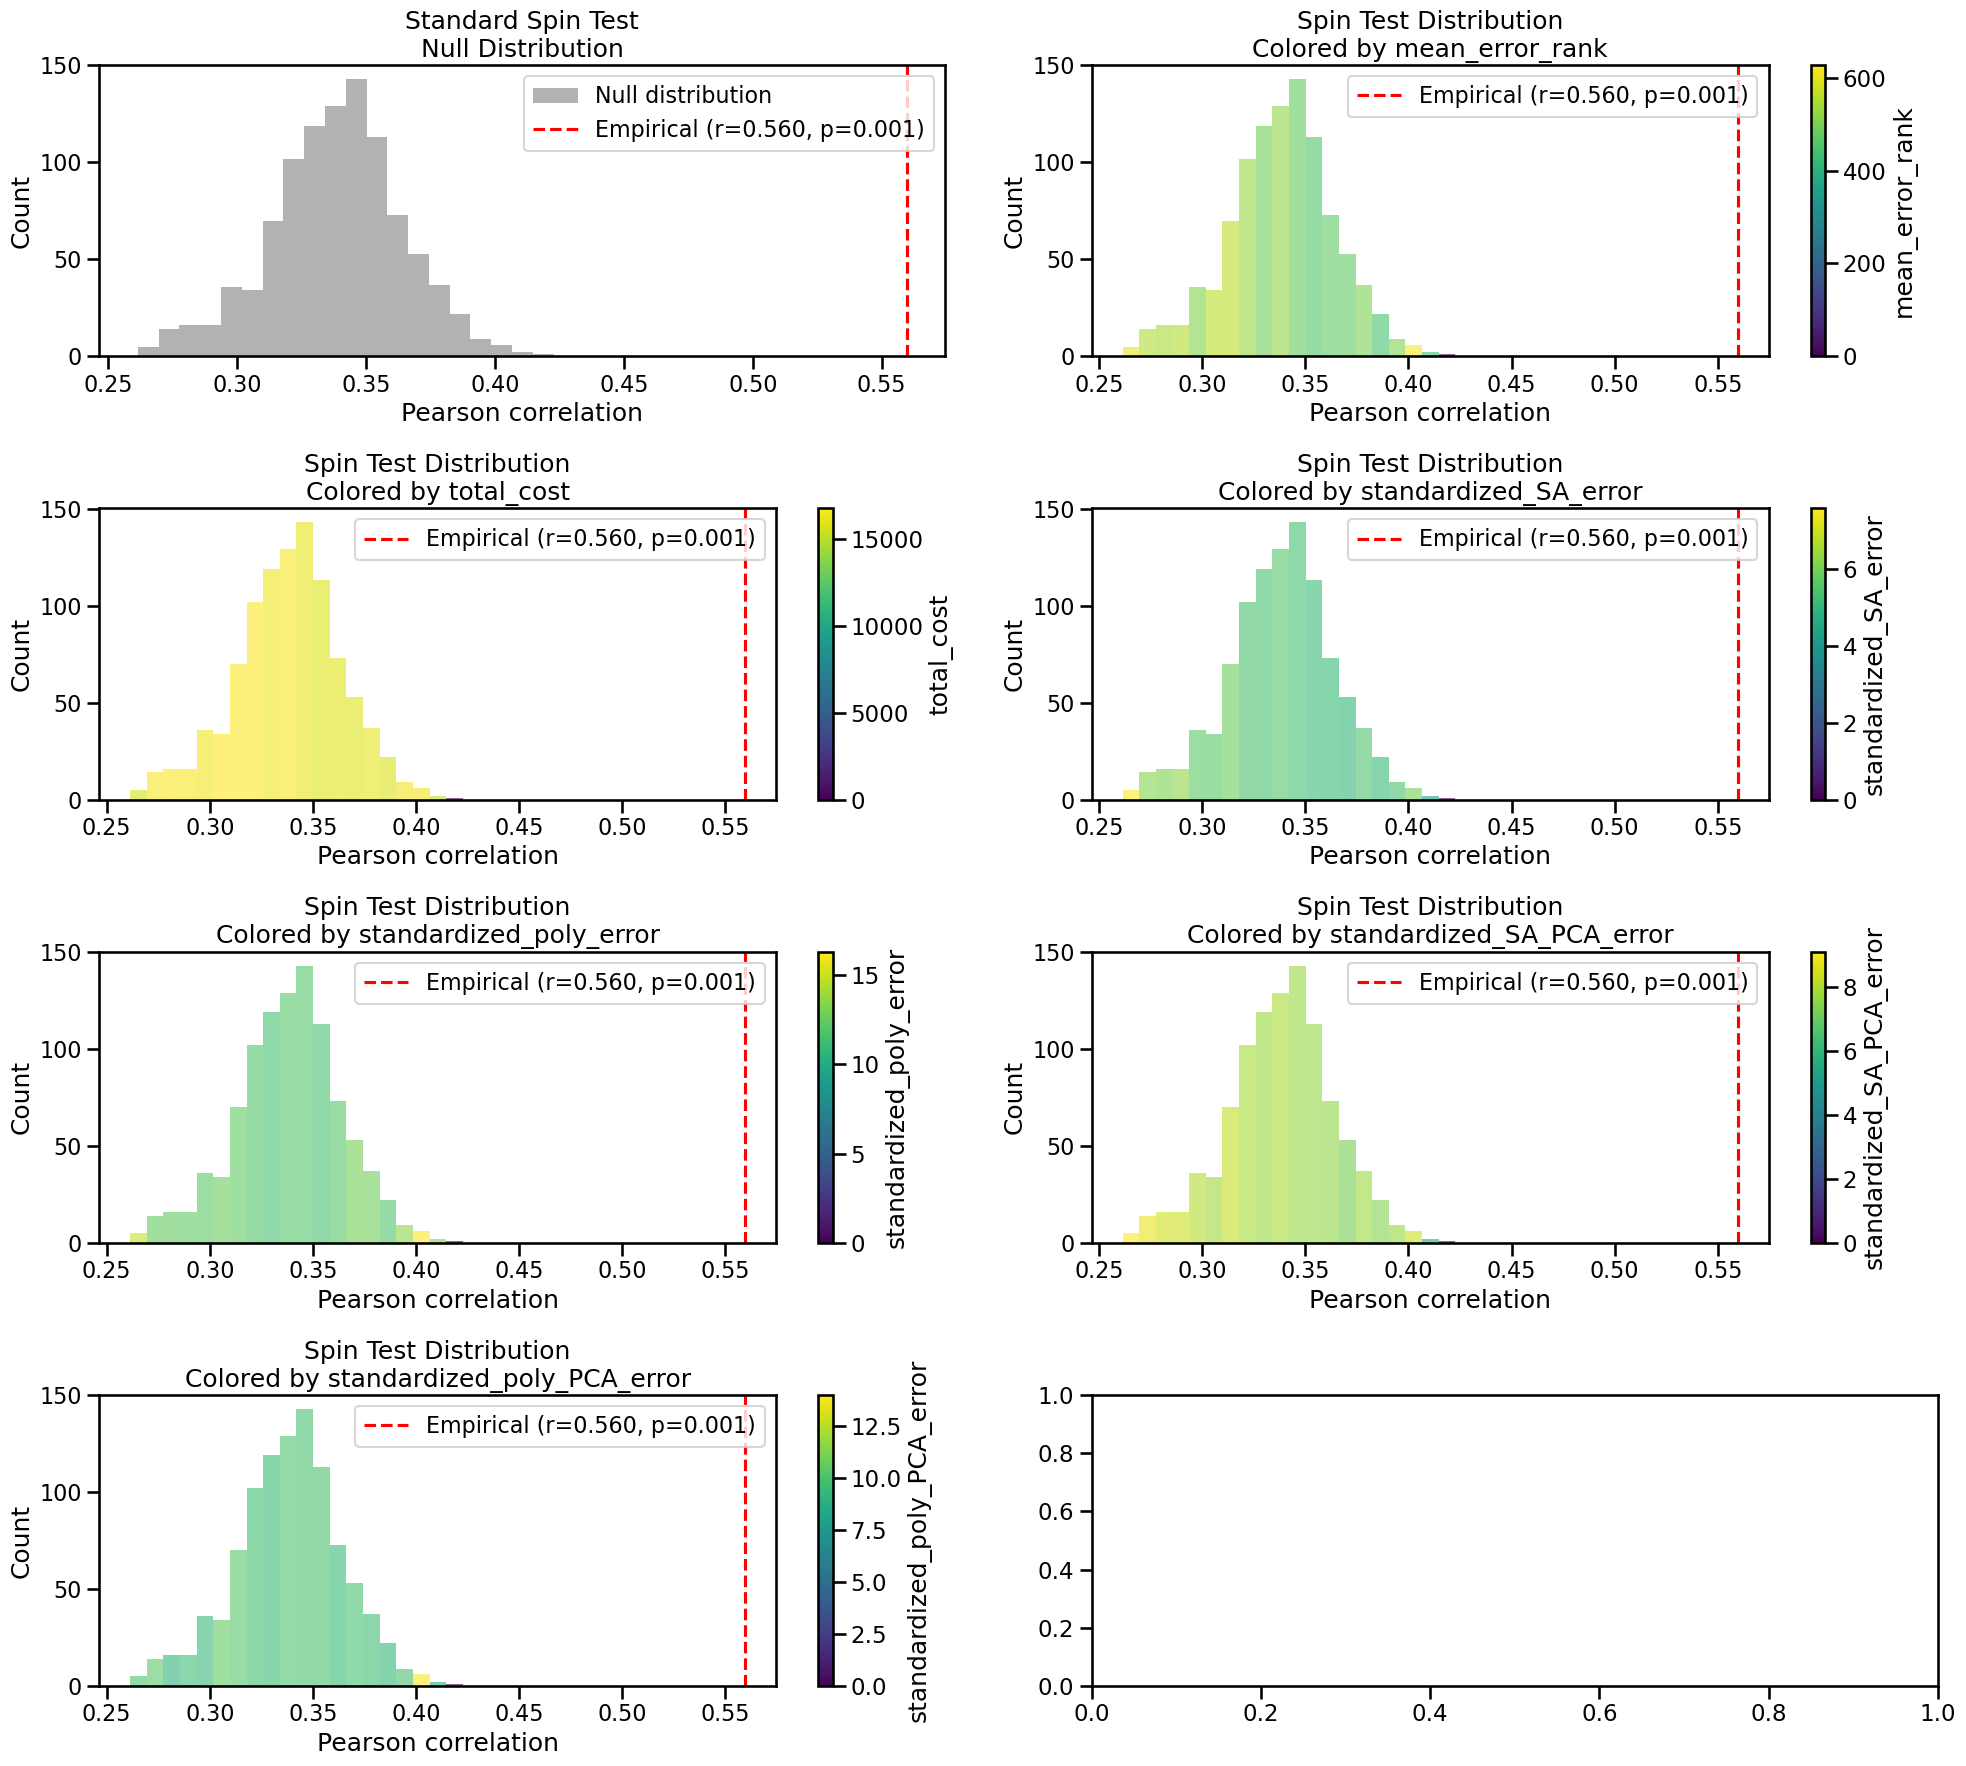

In [70]:
def run_scm_spin_test_precomputed_colored(X, Y_true, valid_indices, spins_df, n_perms=1000, sort_spins='mean_error_rank', bins=25, fontsize=18):
    """
    Run spin test using precomputed spins to generate null distribution
    
    Parameters:
    -----------
    X : array-like
        Gene expression data matrix (n_regions x n_genes)
    Y_true : array-like 
        Connectivity matrix (n_regions x n_regions)
    spins_df : pandas DataFrame
        DataFrame containing precomputed spin indices
    n_components : int
        Number of PLS components to use
    n_perms : int
        Number of null permutations to run
    sort_spins : str
        Metric to sort spins by
    fontsize : int
        Font size for plot text elements
    """
    
    # Sort spins_df by standardized_SA_error in ascending order
    spins_df = spins_df.sort_values(sort_spins, ascending=True)

    # Get spin indices
    cortical_spins_list = spins_df['cortical_spins'].tolist()[:n_perms]
    cortical_spins_list = [eval(x) for x in cortical_spins_list]
    cortical_spin_indices = np.array(cortical_spins_list)
    
    subcortical_spins_list = spins_df['subcortical_spins'].tolist()[:n_perms]
    subcortical_spins_list = [eval(x) for x in subcortical_spins_list]
    subcortical_spin_indices = np.array(subcortical_spins_list)

    # Fit model to true data
    O, Y_pred = fit_scm_closed(X, Y_true)
    
    # Calculate empirical correlation
    Y_pred_empirical = Y_pred
    empirical_corr = pearsonr(Y_true.flatten(), Y_pred_empirical.flatten())[0]

    # Initialize arrays for null correlations and error metrics
    null_corrs = np.zeros(n_perms)
    error_metrics = {
        'mean_error_rank': np.zeros(n_perms),
        'total_cost': np.zeros(n_perms),
        'standardized_SA_error': np.zeros(n_perms),
        'standardized_poly_error': np.zeros(n_perms),
        'standardized_SA_PCA_error': np.zeros(n_perms),
        'standardized_poly_PCA_error': np.zeros(n_perms)
    }
    
    # Generate null distribution
    for i in range(n_perms):
        if i % 50 == 0:
            print(f"permutation: {i}")
          
        # Get spin indices for this permutation
        cortical_spin_idx = cortical_spin_indices[i]
        subcortical_spin_idx = subcortical_spin_indices[i]
        
        # Store error metrics for this permutation
        for metric in error_metrics.keys():
            error_metrics[metric][i] = spins_df[metric].iloc[i]
        
        # Shuffle gene expression
        Y_rotated = Y_true
        X_cortical_rotated = X[cortical_spin_idx]
        X_subcortical_rotated = X[subcortical_spin_idx]
        X_rotated = np.vstack([X_cortical_rotated, X_subcortical_rotated])
        X_rotated = X_rotated[valid_indices]

        # Fit PLS model on rotated data
        O_null, Y_pred_null = fit_scm_closed(X_rotated, Y_rotated)
        
        # Get predictions and calculate correlation
        Y_pred_null = Y_pred_null
        null_corrs[i] = pearsonr(Y_rotated.flatten(), Y_pred_null.flatten())[0]

    # Calculate p-value
    p_value = max(1/(n_perms + 1), np.mean(null_corrs >= empirical_corr))

    # Create figure with 3x2 subplots
    fig, axes = plt.subplots(4, 2, figsize=(20, 18))
    axes = axes.flatten()  # Flatten for easier indexing
    
    # Plot 1: Standard uncolored histogram
    axes[0].hist(null_corrs, bins=bins, alpha=0.6, color='gray', label='Null distribution')
    axes[0].axvline(empirical_corr, color='red', linestyle='--', 
                    label=f'Empirical (r={empirical_corr:.3f}, p={p_value:.3f})')
    axes[0].set_xlabel('Pearson correlation', fontsize=fontsize)
    axes[0].set_ylabel('Count', fontsize=fontsize)
    axes[0].set_title('Standard Spin Test\nNull Distribution', fontsize=fontsize)
    axes[0].legend(fontsize=fontsize-2)
    axes[0].tick_params(labelsize=fontsize-2)
    
    # Calculate bin edges and centers once
    counts, bin_edges = np.histogram(null_corrs, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Plot colored histograms for each error metric
    for idx, (metric, values) in enumerate(error_metrics.items(), 1):
        # Calculate mean error metric for each bin
        bin_errors = np.zeros(len(bin_centers))
        for i in range(len(bin_centers)):
            mask = (null_corrs >= bin_edges[i]) & (null_corrs < bin_edges[i+1])
            bin_errors[i] = np.mean(values[mask]) if np.any(mask) else 0
        
        # Create colored histogram with darker colors for lower values
        norm = plt.Normalize(bin_errors.min(), bin_errors.max())
        colors = plt.cm.viridis(norm(bin_errors))  # Using reversed colormap
        
        # Plot bars
        bars = axes[idx].bar(bin_centers, counts, width=np.diff(bin_edges), 
                            color=colors, alpha=0.6)
        
        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
        plt.colorbar(sm, ax=axes[idx], label=metric)
        
        # Add empirical line
        axes[idx].axvline(empirical_corr, color='red', linestyle='--',
                         label=f'Empirical (r={empirical_corr:.3f}, p={p_value:.3f})')
        
        axes[idx].set_xlabel('Pearson correlation', fontsize=fontsize)
        axes[idx].set_ylabel('Count', fontsize=fontsize)
        axes[idx].set_title(f'Spin Test Distribution\nColored by {metric}', fontsize=fontsize)
        axes[idx].legend(fontsize=fontsize-2)
        axes[idx].tick_params(labelsize=fontsize-2)
    
    plt.tight_layout()
    plt.show()
    
    return empirical_corr, p_value, null_corrs, error_metrics

# Example usage:
empirical_corr, p_value, null_distribution, error_metrics = run_scm_spin_test_precomputed_colored(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y, 
    spins_df=spins_df,
    sort_spins='mean_error_rank',
    n_perms=1000,
    bins=20
)

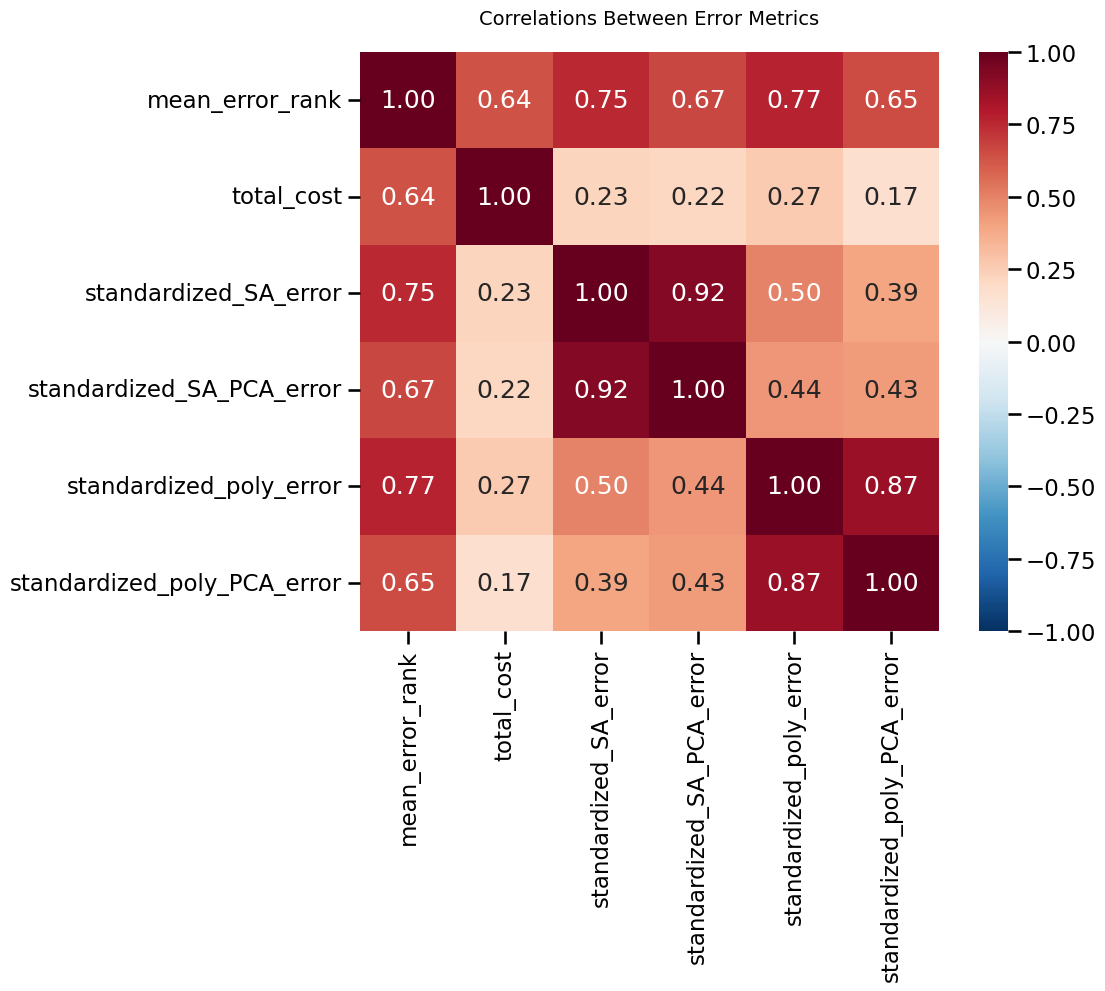

In [24]:
# Calculate correlations between error metrics
error_columns = ['mean_error_rank', 'total_cost', 'standardized_SA_error', 'standardized_SA_PCA_error', 
                'standardized_poly_error', 'standardized_poly_PCA_error']

# Compute correlation matrix
corr_matrix = spins_df[error_columns].corr()

# Create figure
plt.figure(figsize=(12,10))

# Plot heatmap
sns.heatmap(corr_matrix, 
            annot=True, # Show correlation values
            cmap='RdBu_r', # Red-Blue diverging colormap
            vmin=-1, vmax=1, # Fix scale from -1 to 1
            center=0, # Center colormap at 0
            square=True, # Make cells square
            fmt='.2f') # Round correlation values to 2 decimal places

plt.title('Correlations Between Error Metrics', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


